First time use / Primeira utilização

Menu: Terminal -> New Terminal

    pip install -r requirements.txt

Online with [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/joaquimrcarvalho/cipf-comtrade.git/main?labpath=comtrade-api.ipynb):
https://mybinder.org/v2/gh/joaquimrcarvalho/cipf-comtrade.git/main?labpath=comtrade-api.ipynb




# Teste da API UN Comtrade

> The UN COMTRADE is the largest depository of international trade data. It contains well over 5 billion data records since 1962 and is available publicly on the internet. In addition, it offers public and premium data API for easier integration/download.

Informação geral: https://unstats.un.org/wiki/display/comtrade/What+is+UN+Comtrade

API Site: https://comtradedeveloper.un.org 
API specs: https://comtradedeveloper.un.org/api-details#api=comtrade-v1&operation=get-get


Manual metodológico: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf



## Descrições dos códigos HS

Obter tabela em https://github.com/datasets/harmonized-system/blob/master/data/harmonized-system.csv

Copiar para directoria `support`


### Ler a tabela e criar dicionários para descodificação

In [5]:
import pandas as pd

hs_codes_df = pd.read_csv('support/harmonized-system.csv') # read table
hs_codes_map = dict(zip(hs_codes_df.hscode, hs_codes_df.description)) #  dict for decoding
hs_codes_l2 = hs_codes_df[hs_codes_df.level == 2]  # create subset of level 2 codes
hs_l2_map = dict(zip(hs_codes_l2.hscode, hs_codes_l2.description)) # dict for decodung


### Obter os códigos de países e regiões

Ver lista em https://unstats.un.org/wiki/display/comtrade/Country+Code

Em formato JSON disponível em:
 * https://comtrade.un.org/data/cache/reporterAreas.json
 * https://comtrade.un.org/data/cache/partnerAreas.json

Aqui descarregamos e guardamos em `support` para evitar
ligação próxima vez.


In [6]:
import os
import json
import requests
import pandas as pd

fname = 'support/reporter_codes.json'
if os.path.isfile(fname):
    with open(fname) as cached:
        reporter_codes = json.load(cached)
else:
    resp = requests.get("https://comtrade.un.org/data/cache/reporterAreas.json")
    codes = json.loads(resp.content)['results']
    reporter_codes = dict([(a['id'], a['text'])  for a in codes])
    with open(fname, mode="x") as outfile:
        json.dump(reporter_codes,outfile,indent=2)

fname = 'support/partner_codes.json'
if os.path.isfile(fname):
    with open(fname) as cached:
        partner_codes = json.load(cached)
else:
    resp = requests.get("https://comtrade.un.org/data/cache/partnerAreas.json")
    codes = json.loads(resp.content)['results']
    partner_codes = dict([(a['id'], a['text'])  for a in codes])
    with open(fname,mode="x") as outfile:
        json.dump(reporter_codes,outfile,indent=2)

# convert codes to int
m49_reporter_codes_map = { int(k):v for (k,v) in reporter_codes.items() if k!='all'}
m49_partner_codes_map = { int(k):v for (k,v) in partner_codes.items() if k!='all'}
m49_reporter_list = ",".join(map(str,m49_reporter_codes_map.keys()))
m49_partner_list = ",".join(map(str,m49_partner_codes_map.keys()))

Os dados devolvidos pela API incluem códigos no campo `Partner2` que não estão na lista oficial de códigos M49.

Outros utilizadores têm o mesmo problema.

Ver  https://rstudio-pubs-static.s3.amazonaws.com/92321_70509e47e7f041e68f383253cb85751b.html onde se encontra o resultado de cruzamentos dos códigos dos dados e várias versões da lista
M49 e que é útil para completar a lista da FAO.

Ver também esta nota da unstats: https://unstats.un.org/wiki/display/comtrade/Reporter+country+codes+and+their+customs+areas

__Códigos atualmente em falta:__
* __473__ China-Angola Import 2016 partner2Code.
* __899__ Portugal-Angola 2018


In [7]:
reporter_codes.get(473,"Not found")

'Not found'

## Obter os dados de comtrade.un.org

### Parâmetros gerais que não mudam



In [8]:
m49_angola = 24
m49_brazil = 76
m49_cabo_verde = 132
m49_china = 156
m49_hong_kong = 344
m49_macau = 446
m49_guine_equatorial = 226
m49_guine_bissau = 624
m49_mozambique = 508
m49_portugal = 620
m49_stome_principe = 678
m49_timor = 626

# make list of Portuguese Speaking Countries
m49_plp = [m49_angola,m49_brazil,m49_cabo_verde,m49_guine_bissau,
            m49_guine_equatorial,m49_mozambique,m49_portugal,
            m49_stome_principe,m49_timor]
m49_plp_list = ",".join(map(str,m49_plp))




### Função auxiliar para aceder à API un.comtrade


In [9]:
import os
import configparser
import re
import warnings
import json
import requests
import pandas as pd

from typing import Union

fname = 'config.ini'

APIKEY = None
if os.path.isfile(fname):

    config = configparser.ConfigParser()
    config.read('config.ini')
    APIKEY = config['comtrade']['key']


baseUrl_preview = "https://comtradeapi.un.org/public/v1/preview/"
baseUrl_api = "https://comtradeapi.un.org/data/v1/get/"

if APIKEY is None:
    baseUrl = baseUrl_preview
else:
    baseUrl = baseUrl_api



def call_uncomtrade(typeCode: str, freqCode: str, 
                    reporterCode: str = '49', 
                    partnerCode: str = '024,076,132,226,624,508,620,678,626',
                    partner2Code: str = '0',
                    period: str = None,
                    clCode: str = "HS",
                    cmdCode: str = "TOTAL",
                    flowCode: str = "M,X",
                    timeout: int = 10,
                    echo_url: bool = False
                    )-> Union[pd.DataFrame,None]:
    """ Makes a request to UN Comtrade API (public), returns a pandas DataFrame
    
    Parameters
        typeCode: required, C for commodities, S for Services
        freqCode: required, A for annual and M for monthly
        reporterCode: optional, list of M49 codes, default "049" (China)
        partnerCode: optional, list of M49 codes None for all countries, default PLP codes
        partner2Code: optional, list of M49 codes, None for all countries, 0 for agregate, default 0
        period:  optional, aaaa or aaaamm default None (all available periods)
        clCode: Trade classifications: HS, SITC, BEC or EBOPS.
                Available values : HS, SS, B4, B5, EB, EB10, EB02, EBSDMX
        cmdCode: optional, default, "TOTAL"
        flowCode: optional, M=import, X=export,more: RX, RM, MIP, XIP, MOP, XOP, MIF, XIF, DX, FM; default "M,X"
        timeOut: int, max wait time in seconds. Default 10
        echo_url: bool, print url of call, default False
     """
    requestUrl=f"{baseUrl}/{typeCode}/{freqCode}/{clCode}"
    resp = requests.get(requestUrl,
            {
            'reporterCode':reporterCode,
            'period':period,
            'partnerCode':partnerCode,
            'partner2Code':partner2Code,
            'cmdCode':cmdCode,
            'flowCode':flowCode,
            'subscription-key':APIKEY
            },
            timeout=timeout)
    if echo_url:
        sanitize = re.sub("subscription-key=.*","subscription-key=HIDDEN",resp.url)
        print(sanitize)
    if resp.status_code != 200:
        warnings.warn(f"Server returned "+str(resp.status_code),)        
        warnings.warn(str(resp.content))
        df = None
        
    results = json.loads(resp.content)['data']
    if len(results) == 0:
        warnings.warn("Pesquisa não obteve resultados")
        df = None
    else:
        df = pd.DataFrame(results)

        # Convert the country codes to country names
        if 'reporterCode' in df.columns.values:
            df.reporterDesc = df.reporterCode.map(m49_reporter_codes_map)
        if 'partnerCode' in df.columns.values:
            df.partnerDesc = df.partnerCode.map(m49_partner_codes_map)
        if 'partner2Code' in df.columns.values:
            df.partner2Desc = df.partner2Code.map(m49_partner_codes_map)
        # Convert the HS codes
        if 'cmdCode' in df.columns.values:
            df.cmdDesc = df.cmdCode.map(hs_codes_map)
        # Generate a formated version of the value for readability here
        if 'primaryValue' in df.columns.values:
            df['primaryValueFormated'] = df.primaryValue.map('{:,}'.format)
        # return the DataFrame
    return df

## Parâmetros para visualização

Definir as colunas a visualizar, ordem das linhas abaixo para simplificar
posterior visualização dos dados.

Para a lista de todas as colunas disponíveis com uma breve
descrição ver: https://unstats.un.org/wiki/display/comtrade/New+Comtrade+FAQ+for+First+Time+Users?preview=/125141443/135004360/ComtradePlus%20-%20data%20items%20-%2017%20Mar%202020.xlsx



In [10]:
# Colunas mais interessantes do resultado
# escolher de 
#        'typeCode', 'freqCode', 'refPeriodId', 'refYear', 'refMonth',
#        'period', 'reporterCode', 'reporterISO', 'reporterDesc',
#        'flowCode', 'flowDesc', 'partnerCode', 'partnerISO', 'partnerDesc',
#        'partner2Code', 'partner2ISO', 'partner2Desc',
#        'classificationCode', 'classificationSearchCode',
#        'isOriginalClassification', 'cmdCode', 'cmdDesc', 'aggrLevel',
#        'isLeaf', 'customsCode', 'customsDesc', 'mosCode', 'motCode',
#        'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty', 'isQtyEstimated',
#        'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated',
#        'netWgt', 'isNetWgtEstimated', 'grossWgt', 'isGrossWgtEstimated',
#        'cifvalue', 'fobvalue', 'primaryValue', 'legacyEstimationFlag',
#        'isReported', 'isAggregate', 'primaryValueFormated']

cols = ['typeCode','freqCode','reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdCode','cmdDesc','flowCode','isReported','primaryValueFormated','primaryValue']
sort_order = ['reporterDesc','partnerDesc','refYear','refMonth']

## Cobertura dos dados: importações/exportações China-PLP anos disponíveis

In [27]:
",".join(map(str,list(range(1984,2030,1))))

'1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029'

In [28]:
import time

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

flow = "M,X"
year_start = 1984
year_end = 2026
period = ",".join(map(str,list(range(year_start,year_end,1))))
for country_code in m49_plp:
    df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=country_code,
                     partner2Code=0,
                     period=period, # period None returns all the available period
                     timeout=30,
                     echo_url=True
                     )
    print(m49_partner_codes_map[country_code],  df.refYear.unique())
    time.sleep(1)  # avoid stressing the UN server.



https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=1984%2C1985%2C1986%2C1987%2C1988%2C1989%2C1990%2C1991%2C1992%2C1993%2C1994%2C1995%2C1996%2C1997%2C1998%2C1999%2C2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019%2C2020%2C2021%2C2022%2C2023%2C2024%2C2025&partnerCode=24&partner2Code=0&cmdCode=TOTAL&flowCode=M%2CX&subscription-key=HIDDEN
Angola [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021]
https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=1984%2C1985%2C1986%2C1987%2C1988%2C1989%2C1990%2C1991%2C1992%2C1993%2C1994%2C1995%2C1996%2C1997%2C1998%2C1999%2C2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019%2C2020%2C2021%2C2022%2C2023%2C2024%2C2025&partnerCode=76&partner2Code=0&

## Reproduzir os dados do anuário do Forum Macau

O Forum Macau inclui desde 2016 um quadro sumário
dos dados das trocas comerciais entre a China e 
os PLP. Ver https://www.forumchinaplp.org.mo/pt/publications-data-4/annual-reports/

Aqui reproduzimos esses quadros a partir dos
dados atualmente disponíveis no UN Comtrade.

>NOTA: Tal como nos quadros do Forum os valores são
apresentados em 10 mil USD

In [29]:


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f} $10mil'.format

year_start = 1984
year_end = 2026
period = ",".join(map(str,list(range(year_start,year_end,1))))
flow = "M,X"
partnerCode = m49_plp_list
cols2 = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdCode','flowCode','primaryValueFormated']
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     timeout=30
                     )

temp=df.pivot(index=['refYear','partnerDesc',],columns='flowCode',values='primaryValue')
temp['C'] = temp['M'] + temp['X']
temp['S'] = temp['X']-temp['M']
forum_type = temp[['C','X','M','S']]
forum_type.columns=['Trocas','Exportações','Importações','Saldo']
forum_type.div(10000).fillna("-")


Trocas         Exportações  \
refYear partnerDesc                                                      
1992    Angola                     3,788.21 $10mil       847.28 $10mil   
        Brazil                    58,405.38 $10mil     6,475.17 $10mil   
        Cabo Verde                               -        16.15 $10mil   
        Equatorial Guinea             26.09 $10mil        18.08 $10mil   
        Guinea-Bissau                            -       240.16 $10mil   
        Mozambique                 5,911.89 $10mil     2,072.90 $10mil   
        Portugal                   6,691.20 $10mil     4,399.26 $10mil   
        Sao Tome and Principe                    -         2.48 $10mil   
1993    Angola                    19,191.74 $10mil     1,120.69 $10mil   
        Brazil                   105,523.37 $10mil    19,216.62 $10mil   
        Cabo Verde                               -        75.49 $10mil   
        Equatorial Guinea             66.34 $10mil        63.54 $10mil   
        Guinea-Bissau                376.75 $10mil       271.63 $10mil   
        Mozambique                 2,326.57 $10mil     1,654.82 $10mil   
        Portugal                  11,233.26 $10mil     7,392.87 $10mil   
        Sao Tome and Principe                    -        37.96 $10mil   
1994    Angola                     6,046.63 $10mil     1,248.20 $10mil   
        Brazil                   142,116.82 $10mil    36,239.09 $10mil   
        Cabo Verde                               -        42.44 $10mil   
        Equatorial Guinea             68.25 $10mil        58.48 $10mil   
        Guinea-Bissau                491.43 $10mil       400.30 $10mil   
        Mozambique                 1,209.43 $10mil       651.82 $10mil   
        Portugal                   9,006.80 $10mil     7,451.75 $10mil   
        Sao Tome and Principe                    -        16.10 $10mil   
1995    Angola                    15,806.66 $10mil     2,115.93 $10mil   
        Brazil                   199,058.88 $10mil    75,905.87 $10mil   
        Cabo Verde                               -        38.03 $10mil   
        Equatorial Guinea          1,496.36 $10mil       233.04 $10mil   
        Guinea-Bissau                109.41 $10mil       109.09 $10mil   
        Mozambique                 1,261.61 $10mil     1,152.31 $10mil   
        Portugal                  14,468.75 $10mil    10,605.39 $10mil   
        Sao Tome and Principe                    -        21.32 $10mil   
1996    Angola                    27,228.48 $10mil     2,853.37 $10mil   
        Brazil                   224,699.57 $10mil    76,293.05 $10mil   
        Cabo Verde                               -        27.49 $10mil   
        Equatorial Guinea          2,157.18 $10mil       597.07 $10mil   
        Guinea-Bissau                            -        46.26 $10mil   
        Mozambique                 1,143.34 $10mil     1,123.52 $10mil   
        Portugal                  16,445.65 $10mil    13,379.79 $10mil   
        Sao Tome and Principe         25.67 $10mil        25.62 $10mil   
1997    Angola                    63,262.47 $10mil     2,912.85 $10mil   
        Brazil                   253,335.06 $10mil   104,438.93 $10mil   
        Cabo Verde                               -        40.54 $10mil   
        Equatorial Guinea          8,082.29 $10mil       333.51 $10mil   
        Guinea-Bissau                176.09 $10mil        72.23 $10mil   
        Mozambique                 1,667.10 $10mil     1,594.12 $10mil   
        Portugal                  21,081.67 $10mil    16,614.98 $10mil   
        Sao Tome and Principe                    -        10.79 $10mil   
1998    Angola                    19,035.07 $10mil     3,665.30 $10mil   
        Brazil                   221,846.73 $10mil   108,536.40 $10mil   
        Cabo Verde                               -       196.08 $10mil   
        Equatorial Guinea          7,184.51 $10mil       293.72 $10mil   
        Guinea-Bissau                           

### Gravar em Excel

In [30]:
real_period = forum_type.index.get_level_values('refYear')
start_year=min(real_period)
end_year=max(real_period)
period=f"{start_year}-{end_year}"
forum_type.to_excel(f"./downloads/quadros_forum_{period}.xlsx")
forum_type.div(10).to_excel(f"./downloads/quadros_forum_10_{period}.xlsx")
forum_type.div(10000).to_excel(f"./downloads/quadros_forum_10mil_{period}.xlsx")

## Gráficos dos dados formato Forum Macau

### Gráficos das trocas comerciais

In [31]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Trocas' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento            Trocas                                   \
Parceiro             Angola             Brazil    Cabo Verde   
refYear                                                        
1992          37,882,057.00     584,053,801.00           NaN   
1993         191,917,410.00   1,055,233,729.00           NaN   
1994          60,466,329.00   1,421,168,235.00           NaN   
1995         158,066,638.00   1,990,588,766.00           NaN   
1996         272,284,848.00   2,246,995,732.00           NaN   
1997         632,624,657.00   2,533,350,625.00           NaN   
1998         190,350,740.00   2,218,467,328.00           NaN   
1999         372,014,853.00   1,844,531,871.00           NaN   
2000       1,876,428,476.00   2,844,986,286.00           NaN   
2001         767,549,929.00   3,698,157,551.00           NaN   
2002       1,148,360,244.00   4,469,402,237.00  1,839,631.00   
2003       2,351,726,095.00   7,985,547,602.00  2,596,450.00   
2004       4,910,857,051.00  12,346,965,534.00           NaN   
2005       6,954,622,660.00  14,819,733,513.00           NaN   
2006      11,827,480,740.00  20,289,600,892.00 10,094,434.00   
2007      14,123,183,254.00  29,740,543,392.00 16,826,538.00   
2008      25,324,993,585.00  48,670,899,923.00           NaN   
2009      17,061,790,710.00  42,399,500,775.00 35,405,225.00   
2010      24,818,922,030.00  62,560,099,217.00 34,347,153.00   
2011      27,706,333,858.00  84,223,427,605.00 49,763,747.00   
2012      37,601,068,187.00  85,694,760,113.00 57,491,588.00   
2013      35,936,728,280.00  90,194,593,897.00 61,996,254.00   
2014      37,081,011,865.00  86,543,359,382.00 51,226,457.00   
2015      19,718,757,266.00  71,501,583,488.00 43,322,801.00   
2016      15,646,515,704.00  67,831,200,011.00 48,754,719.00   
2017      22,956,162,692.00  87,807,693,508.00 69,247,880.00   
2018      28,079,647,462.00 111,234,639,172.00 78,556,148.00   
2019      25,893,129,559.00 115,501,610,959.00 64,195,682.00   
2020      16,505,822,542.00 120,470,436,745.00 79,046,671.00   
2021      23,399,776,998.00 163,490,100,674.00 85,684,661.00   

Movimento                                                                    \
Parceiro  Equatorial Guinea Guinea-Bissau       Mozambique         Portugal   
refYear                                                                       
1992             260,869.00           NaN    59,118,852.00    66,912,040.00   
1993             663,395.00  3,767,504.00    23,265,735.00   112,332,647.00   
1994             682,523.00  4,914,303.00    12,094,253.00    90,068,016.00   
1995          14,963,606.00  1,094,106.00    12,616,064.00   144,687,454.00   
1996          21,571,812.00           NaN    11,433,431.00   164,456,527.00   
1997          80,822,873.00  1,760,864.00    16,671,022.00   210,816,704.00   
1998          71,845,073.00           NaN    13,761,286.00   227,541,780.00   
1999         169,599,635.00  3,376,647.00    22,230,406.00   258,231,893.00   
2000         323,027,036.00  4,803,101.00    33,483,844.00   307,772,721.00   
2001         511,935,551.00           NaN    33,234,945.00   332,028,165.00   
2002         386,013,778.00           NaN    48,510,137.00   383,585,176.00   
2003         416,934,554.00           NaN    71,620,107.00   600,870,201.00   
2004       1,006,774,432.00  6,023,555.00   119,440,424.00   869,155,651.00   
2005       1,456,635,405.00           NaN   165,005,198.00 1,235,786,772.00   
2006       2,578,699,652.00  5,677,120.00   207,712,591.00 1,713,473,333.00   
2007       1,790,074,148.00  7,481,817.00   287,801,009.00 2,219,394,424.00   
2008       2,545,262,786.00  7,389,560.00   421,877,323.00 2,704,592,097.00   
2009       1,413,495,293.00 24,810,827.00   516,688,179.00 2,404,446,058.00   
2010       1,054,898,266.00 13,296,570.00   697,468,565.00 3,267,743,710.00   
2011       1,939,264,554.00 18,963,628.00   957,488,225.00 3,963,497,677.00   
2012       2,184,237,487.00 22,528,109.00 1,344,207,513.00 4,015,739,5

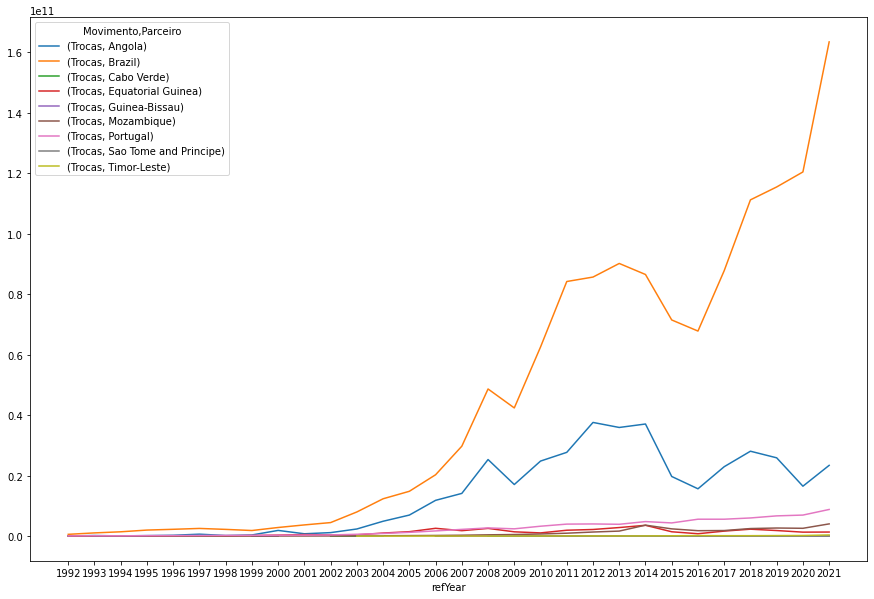

In [32]:
import matplotlib.pyplot as plt
graph_data.plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}.png")

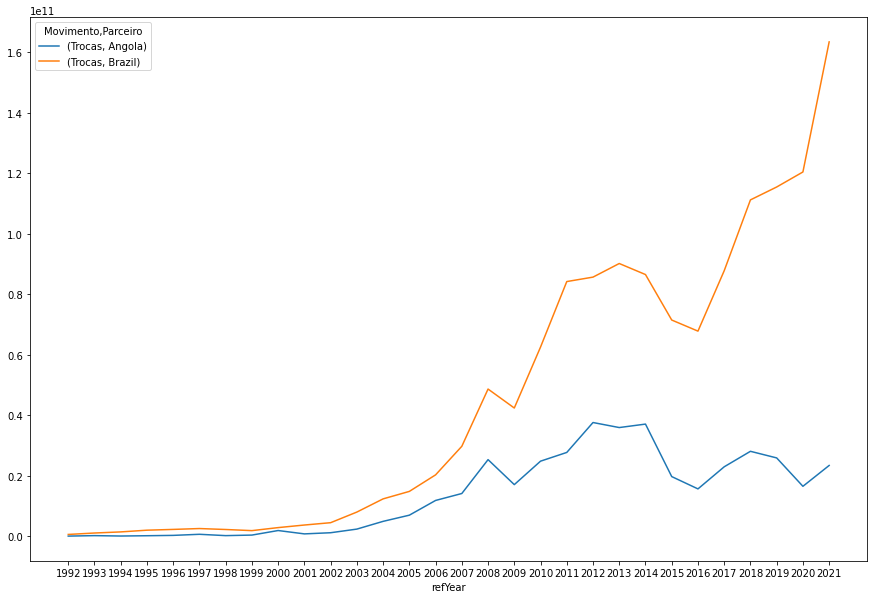

In [33]:

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ao_br.png")

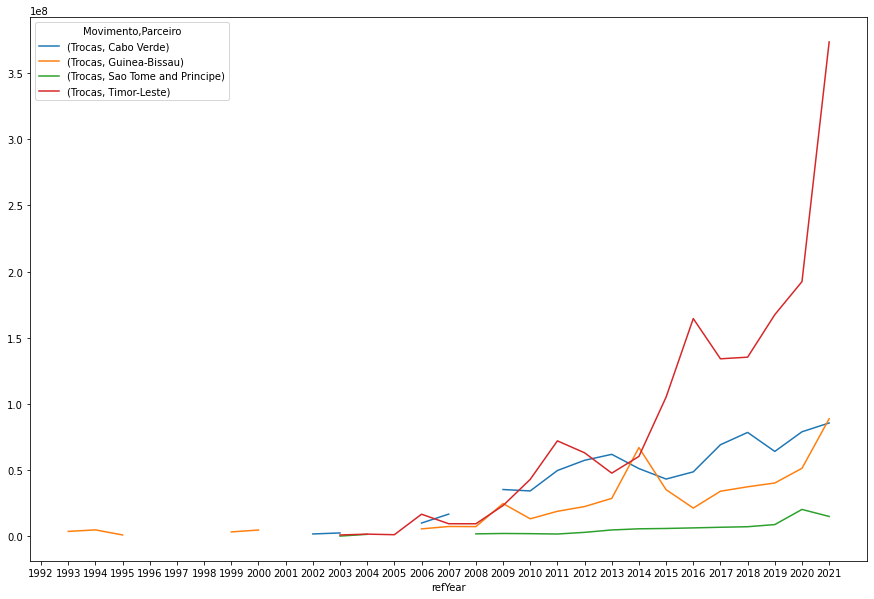

In [34]:
import matplotlib.pyplot as plt

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_cb_gb_stp_tl.png")


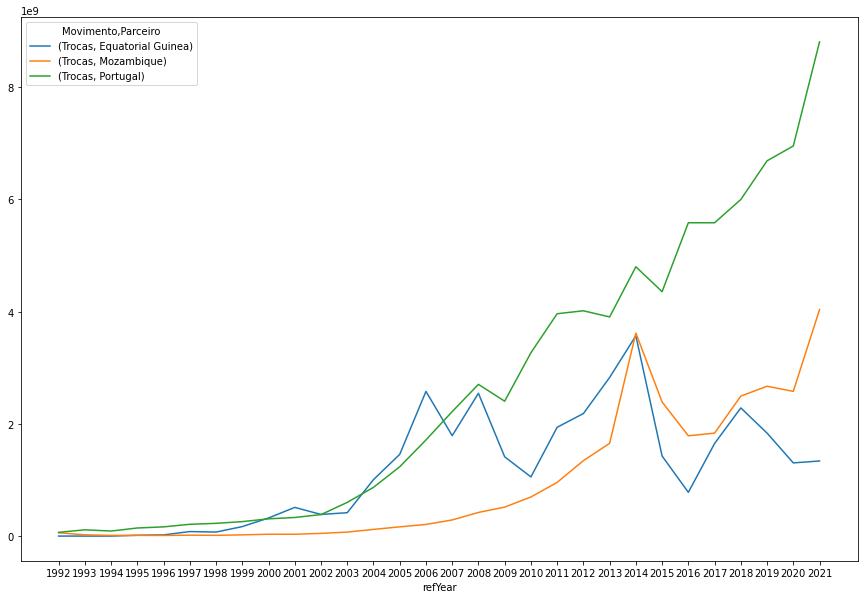

In [35]:
import matplotlib.pyplot as plt

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ge_mo_pt.png")

### Gráficos importações


In [36]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Importações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento       Importações                                                    \
Parceiro             Angola             Brazil   Cabo Verde Equatorial Guinea   
refYear                                                                         
1992          29,409,207.00     519,302,066.00          NaN         80,044.00   
1993         180,710,462.00     863,067,513.00          NaN         28,001.00   
1994          47,984,324.00   1,058,777,325.00          NaN         97,694.00   
1995         136,907,302.00   1,231,530,073.00          NaN     12,633,236.00   
1996         243,751,143.00   1,484,065,187.00          NaN     15,601,149.00   
1997         603,496,146.00   1,488,961,327.00          NaN     77,487,760.00   
1998         153,697,712.00   1,133,103,360.00          NaN     68,907,888.00   
1999         355,651,156.00     968,529,665.00          NaN    167,101,673.00   
2000       1,842,692,967.00   1,621,440,791.00          NaN    319,477,975.00   
2001         721,828,095.00   2,347,232,533.00          NaN    508,580,964.00   
2002       1,087,049,343.00   3,003,019,897.00       262.00    382,726,097.00   
2003       2,205,934,880.00   5,842,291,688.00       353.00    411,886,532.00   
2004       4,717,339,146.00   8,672,861,322.00          NaN    996,649,809.00   
2005       6,581,828,714.00   9,992,524,117.00          NaN  1,437,833,974.00   
2006      10,933,295,107.00  12,909,495,161.00       344.00  2,537,591,664.00   
2007      12,888,664,603.00  18,342,070,986.00        50.00  1,697,283,346.00   
2008      22,382,523,829.00  29,863,442,631.00          NaN  2,267,871,882.00   
2009      14,675,830,702.00  28,280,982,512.00       193.00  1,055,071,473.00   
2010      22,815,049,454.00  38,099,447,351.00    12,060.00    598,657,025.00   
2011      24,922,180,492.00  52,386,750,280.00    12,062.00  1,672,947,440.00   
2012      33,561,896,917.00  52,281,126,771.00     1,115.00  1,822,803,333.00   
2013      31,972,669,347.00  54,299,122,653.00       160.00  2,469,917,950.00   
2014      31,106,015,046.00  51,653,224,893.00     3,020.00  3,217,190,248.00   
2015      16,001,611,383.00  44,089,358,062.00    22,606.00  1,166,496,464.00   
2016      13,966,117,080.00  45,855,047,246.00    83,281.00    631,851,506.00   
2017      20,698,709,467.00  58,857,155,273.00     8,010.00  1,483,835,026.00   
2018      25,826,510,355.00  77,569,499,985.00   290,397.00  2,139,372,096.00   
2019      23,837,402,142.00  79,962,547,047.00    28,691.00  1,723,064,057.00   
2020      14,757,730,338.00  85,517,209,220.00 1,209,992.00  1,182,549,225.00   
2021      20,908,231,317.00 109,877,876,281.00 1,146,922.00  1,215,142,465.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
1992                NaN    38,389,843.00    22,919,478.00   
1993       1,051,163.00     6,717,531.00    38,403,953.00   
1994         911,339.00     5,576,033.00    15,550,507.00   
1995           3,214.00     1,092,985.00    38,633,592.00   
1996                NaN       198,206.00    30,658,597.00   
1997       1,038,609.00       729,796.00    44,666,900.00   
1998                NaN       427,301.00    26,952,180.00   
1999         195,510.00     3,299,368.00    38,288,657.00   
2000         181,700.00     8,777,791.00    46,949,131.00   
2001                NaN    11,193,891.00    71,460,151.00   
2002                NaN    22,578,190.00    82,705,528.00   
2003                NaN    26,591,793.00   194,613,740.00   
2004          29,251.00    44,286,108.00   280,896,511.00   
2005                NaN    73,527,324.00   323,834,266.00   
2006              64.00    79,772,228.00   353,809,128.00   
2007         172,994.00   124,248,069.00   384,642,280.00   
2008       1,242,562.00   125,882,374.00   387,489,834.00   
2009       1,617,183.00   177,554,369.00   480,929,852.00   
2010       3,862,870.00   201,077,529.00   75

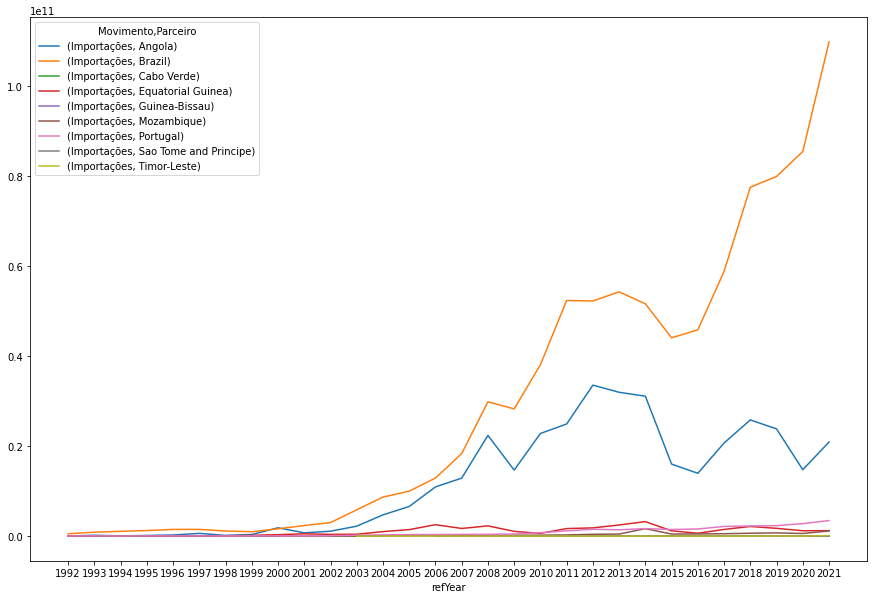

In [37]:
import matplotlib.pyplot as plt
graph_data.plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}.png")

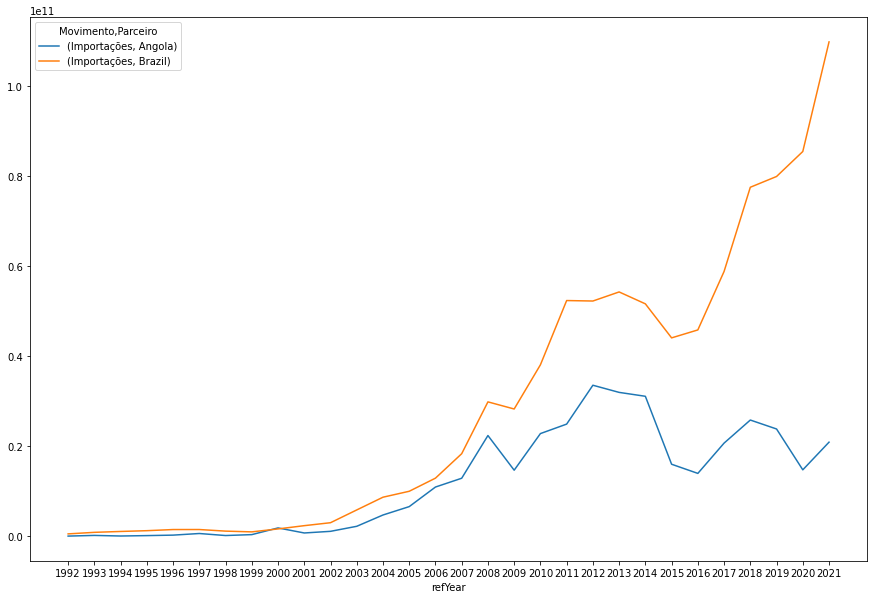

In [38]:
detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ao_br.png")

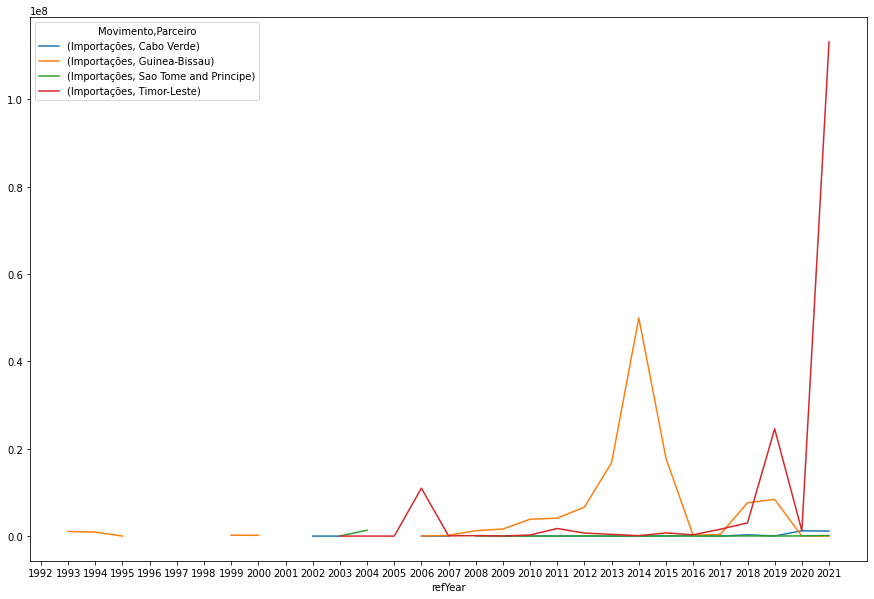

In [39]:
import matplotlib.pyplot as plt

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_cb_gb_stp_tl.png")


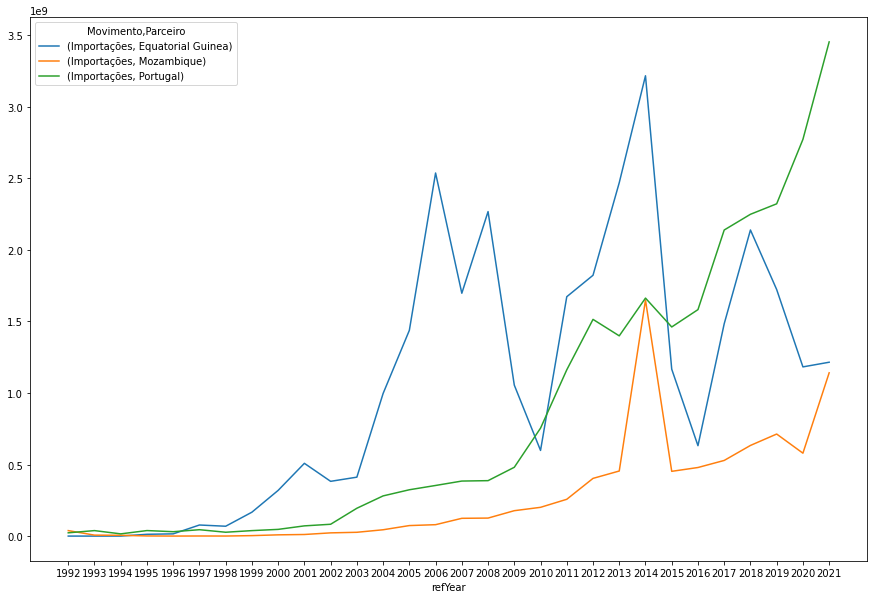

In [40]:
import matplotlib.pyplot as plt

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ge_mo_pt.png")

### Gráficos exportações

In [41]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Exportações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento      Exportações                                                    \
Parceiro            Angola            Brazil    Cabo Verde Equatorial Guinea   
refYear                                                                        
1992          8,472,850.00     64,751,735.00    161,485.00        180,825.00   
1993         11,206,948.00    192,166,216.00    754,935.00        635,394.00   
1994         12,482,005.00    362,390,910.00    424,394.00        584,829.00   
1995         21,159,336.00    759,058,693.00    380,342.00      2,330,370.00   
1996         28,533,705.00    762,930,545.00    274,927.00      5,970,663.00   
1997         29,128,511.00  1,044,389,298.00    405,394.00      3,335,113.00   
1998         36,653,028.00  1,085,363,968.00  1,960,845.00      2,937,185.00   
1999         16,363,697.00    876,002,206.00  3,141,087.00      2,497,962.00   
2000         33,735,509.00  1,223,545,495.00  5,178,211.00      3,549,061.00   
2001         45,721,834.00  1,350,925,018.00  2,212,932.00      3,354,587.00   
2002         61,310,901.00  1,466,382,340.00  1,839,369.00      3,287,681.00   
2003        145,791,215.00  2,143,255,914.00  2,596,097.00      5,048,022.00   
2004        193,517,905.00  3,674,104,212.00  2,746,211.00     10,124,623.00   
2005        372,793,946.00  4,827,209,396.00  5,187,788.00     18,801,431.00   
2006        894,185,633.00  7,380,105,731.00 10,094,090.00     41,107,988.00   
2007      1,234,518,651.00 11,398,472,406.00 16,826,488.00     92,790,802.00   
2008      2,942,469,756.00 18,807,457,292.00 14,953,954.00    277,390,904.00   
2009      2,385,960,008.00 14,118,518,263.00 35,405,032.00    358,423,820.00   
2010      2,003,872,576.00 24,460,651,866.00 34,335,093.00    456,241,241.00   
2011      2,784,153,366.00 31,836,677,325.00 49,751,685.00    266,317,114.00   
2012      4,039,171,270.00 33,413,633,342.00 57,490,473.00    361,434,154.00   
2013      3,964,058,933.00 35,895,471,244.00 61,996,094.00    357,517,241.00   
2014      5,974,996,819.00 34,890,134,489.00 51,223,437.00    352,515,328.00   
2015      3,717,145,883.00 27,412,225,426.00 43,300,195.00    261,389,919.00   
2016      1,680,398,624.00 21,976,152,765.00 48,671,438.00    148,253,831.00   
2017      2,257,453,225.00 28,950,538,235.00 69,239,870.00    166,217,956.00   
2018      2,253,137,107.00 33,665,139,187.00 78,265,751.00    145,146,401.00   
2019      2,055,727,417.00 35,539,063,912.00 64,166,991.00    113,204,451.00   
2020      1,748,092,204.00 34,953,227,525.00 77,836,679.00    122,120,216.00   
2021      2,491,545,681.00 53,612,224,393.00 84,537,739.00    123,984,094.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
1992       2,401,586.00    20,729,009.00    43,992,562.00   
1993       2,716,341.00    16,548,204.00    73,928,694.00   
1994       4,002,964.00     6,518,220.00    74,517,509.00   
1995       1,090,892.00    11,523,079.00   106,053,862.00   
1996         462,599.00    11,235,225.00   133,797,930.00   
1997         722,255.00    15,941,226.00   166,149,804.00   
1998       1,452,681.00    13,333,985.00   200,589,600.00   
1999       3,181,137.00    18,931,038.00   219,943,236.00   
2000       4,621,401.00    24,706,053.00   260,823,590.00   
2001       8,299,380.00    22,041,054.00   260,568,014.00   
2002       4,503,979.00    25,931,947.00   300,879,648.00   
2003      12,350,232.00    45,028,314.00   406,256,461.00   
2004       5,994,304.00    75,154,316.00   588,259,140.00   
2005       5,793,889.00    91,477,874.00   911,952,506.00   
2006       5,677,056.00   127,940,363.00 1,359,664,205.00   
2007       7,308,823.00   163,552,940.00 1,834,752,144.00   
2008       6,146,998.00   295,994,949.00 2,317,102,263.00   
2009      23,193,644.00   339,133,810.00 1,923,516,206.00   
2010       9,433,700.00   496,391,036.00 2,513,317,692.00   
2011      14,850,

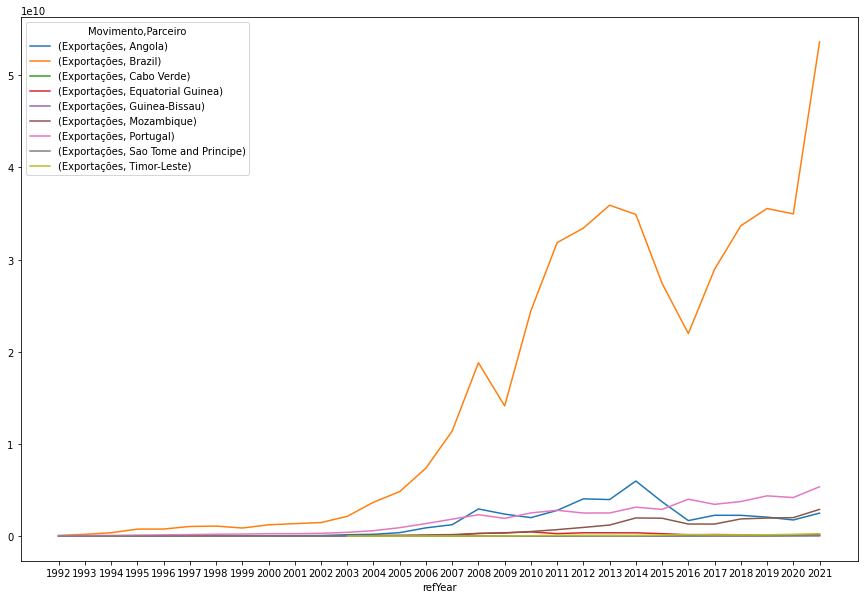

In [42]:
import matplotlib.pyplot as plt
graph_data.plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}.png")

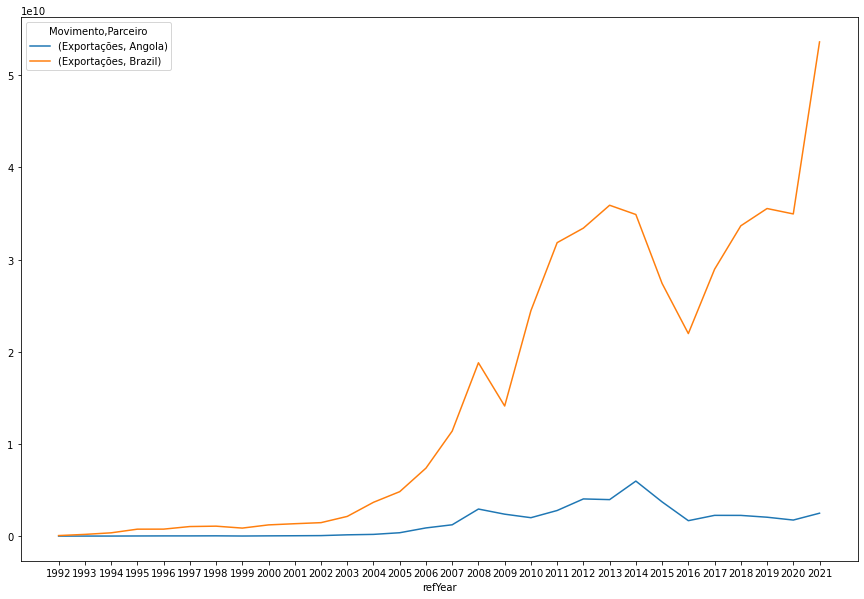

In [43]:
detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ao_br.png")

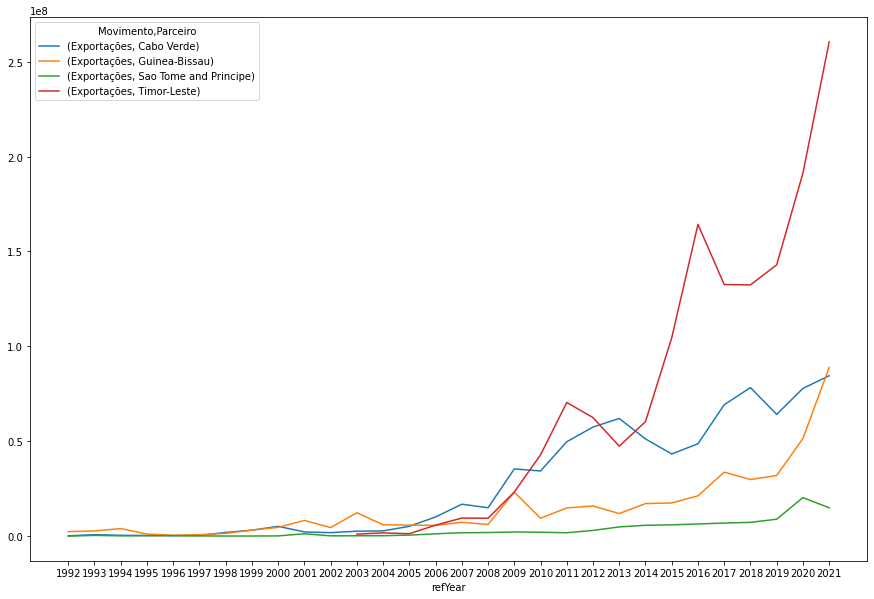

In [44]:
detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_cb_gb_stp_tl.png")


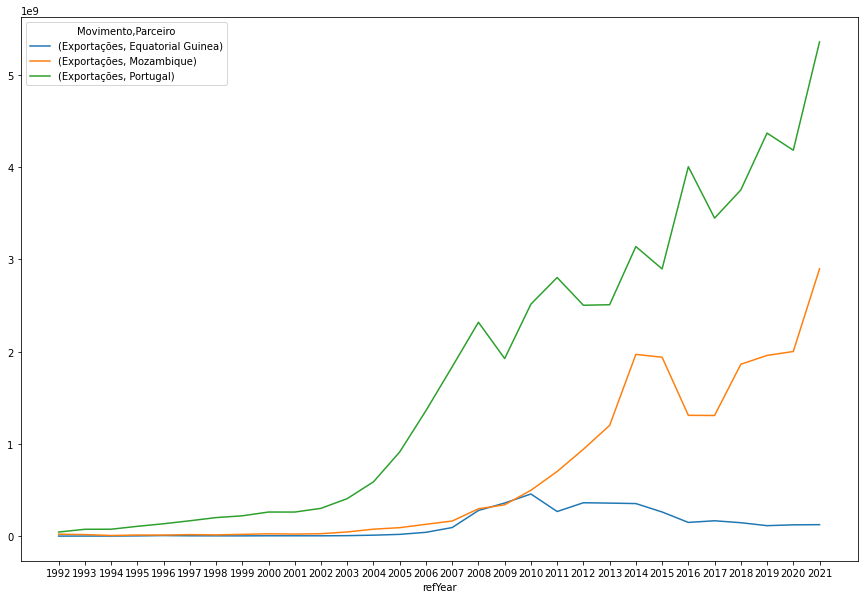

In [45]:
import matplotlib.pyplot as plt

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ge_mo_pt.png")

### Gráficos saldo (China: exportações-importações)

In [46]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Saldo' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento              Saldo                                   \
Parceiro              Angola             Brazil    Cabo Verde   
refYear                                                         
1992          -20,936,357.00    -454,550,331.00           NaN   
1993         -169,503,514.00    -670,901,297.00           NaN   
1994          -35,502,319.00    -696,386,415.00           NaN   
1995         -115,747,966.00    -472,471,380.00           NaN   
1996         -215,217,438.00    -721,134,642.00           NaN   
1997         -574,367,635.00    -444,572,029.00           NaN   
1998         -117,044,684.00     -47,739,392.00           NaN   
1999         -339,287,459.00     -92,527,459.00           NaN   
2000       -1,808,957,458.00    -397,895,296.00           NaN   
2001         -676,106,261.00    -996,307,515.00           NaN   
2002       -1,025,738,442.00  -1,536,637,557.00  1,839,107.00   
2003       -2,060,143,665.00  -3,699,035,774.00  2,595,744.00   
2004       -4,523,821,241.00  -4,998,757,110.00           NaN   
2005       -6,209,034,768.00  -5,165,314,721.00           NaN   
2006      -10,039,109,474.00  -5,529,389,430.00 10,093,746.00   
2007      -11,654,145,952.00  -6,943,598,580.00 16,826,438.00   
2008      -19,440,054,073.00 -11,055,985,339.00           NaN   
2009      -12,289,870,694.00 -14,162,464,249.00 35,404,839.00   
2010      -20,811,176,878.00 -13,638,795,485.00 34,323,033.00   
2011      -22,138,027,126.00 -20,550,072,955.00 49,739,623.00   
2012      -29,522,725,647.00 -18,867,493,429.00 57,489,358.00   
2013      -28,008,610,414.00 -18,403,651,409.00 61,995,934.00   
2014      -25,131,018,227.00 -16,763,090,404.00 51,220,417.00   
2015      -12,284,465,500.00 -16,677,132,636.00 43,277,589.00   
2016      -12,285,718,456.00 -23,878,894,481.00 48,588,157.00   
2017      -18,441,256,242.00 -29,906,617,038.00 69,231,860.00   
2018      -23,573,373,248.00 -43,904,360,798.00 77,975,354.00   
2019      -21,781,674,725.00 -44,423,483,135.00 64,138,300.00   
2020      -13,009,638,134.00 -50,563,981,695.00 76,626,687.00   
2021      -18,416,685,636.00 -56,265,651,888.00 83,390,817.00   

Movimento                                                                     \
Parceiro  Equatorial Guinea  Guinea-Bissau       Mozambique         Portugal   
refYear                                                                        
1992             100,781.00            NaN   -17,660,834.00    21,073,084.00   
1993             607,393.00   1,665,178.00     9,830,673.00    35,524,741.00   
1994             487,135.00   3,091,625.00       942,187.00    58,967,002.00   
1995         -10,302,866.00   1,087,678.00    10,430,094.00    67,420,270.00   
1996          -9,630,486.00            NaN    11,037,019.00   103,139,333.00   
1997         -74,152,647.00    -316,354.00    15,211,430.00   121,482,904.00   
1998         -65,970,703.00            NaN    12,906,684.00   173,637,420.00   
1999        -164,603,711.00   2,985,627.00    15,631,670.00   181,654,579.00   
2000        -315,928,914.00   4,439,701.00    15,928,262.00   213,874,459.00   
2001        -505,226,377.00            NaN    10,847,163.00   189,107,863.00   
2002        -379,438,416.00            NaN     3,353,757.00   218,174,120.00   
2003        -406,838,510.00            NaN    18,436,521.00   211,642,721.00   
2004        -986,525,186.00   5,965,053.00    30,868,208.00   307,362,629.00   
2005      -1,419,032,543.00            NaN    17,950,550.00   588,118,240.00   
2006      -2,496,483,676.00   5,676,992.00    48,168,135.00 1,005,855,077.00   
2007      -1,604,492,544.00   7,135,829.00    39,304,871.00 1,450,109,864.00   
2008      -1,990,480,978.00   4,904,436.00   170,112,575.00 1,929,612,429.00   
2009        -696,647,653.00  21,576,461.00   161,579,441.00 1,442,586,354.00   
2010        -142,415,784.00   5,570,830.00   295,313,507.00 1,758,891,674.00   
2011      -1,406,630,326.00  10,738,246.00   443,005,827.00 1,639,369,807.00   
2012      -1,4

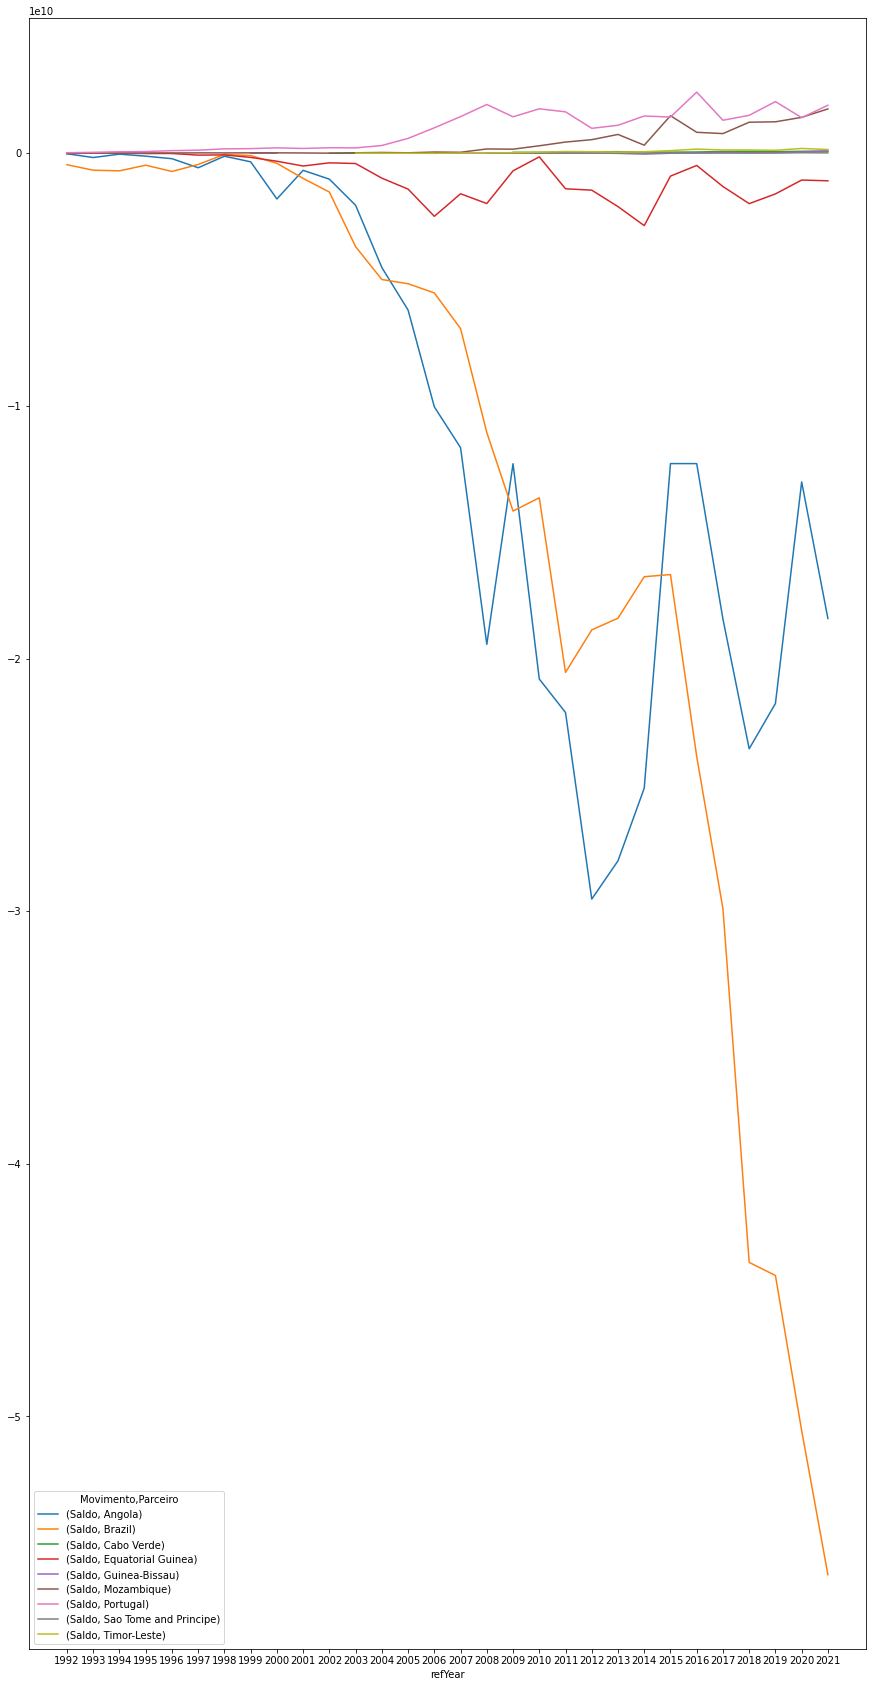

In [47]:
import matplotlib.pyplot as plt
graph_data.plot.line(figsize=(15,30),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}.png")

## China, trocas mais importantes com os PLP

Obtem os totais agregados com nível 2 de código HS e lista os primeiros

In [25]:
rank_filter = 5  # número de importações mais relevantes
years = "2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021"
flowCode = 'M,X'
pco_cols = ['reporterDesc','partnerDesc','refYear','rank','cmdCode','cmdDesc',
            'flowCode','primaryValue']
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode="AG2",
                     reporterCode=m49_china,
                     partnerCode=m49_plp_list,
                     period=years,
                     timeout=120
                     )

pco = df.sort_values(['partnerDesc','refYear','primaryValue'], ascending=[True,True,False])
pco['rank'] = pco.groupby(['partnerDesc','refYear','flowCode'])["primaryValue"].rank(method="dense", ascending=False)
pco_top5 = pco[pco['rank'] <= rank_filter]
# save to Excel
pco_top5_sorted = pco_top5[pco_cols].set_index(['reporterDesc','partnerDesc','refYear','flowCode','rank']).sort_index()

# Prepare file name for Excel output
filename_note=f"{years.replace(',','_')}_{flowCode.replace(',','_')}"  # change to append to filename
excel_file_name = f"./downloads/china_plp_top5_{filename_note}.xlsx"
excel_file = pd.ExcelWriter(excel_file_name)
# Save data
pco_top5_sorted.to_excel(excel_file, sheet_name="comtrade", startrow=2)
excel_file.close()
# Write title in first row TBD
excel_file_title = f"Trocas Comerciais China-PLP, top {rank_filter} produtos (M=Importações, X=Exportações), {years}, valores USD"
print(excel_file_title)
print("Guardado em:",excel_file_name)
# show
pd.options.display.max_colwidth=100
pco_top5_sorted

Trocas Comerciais China-PLP, top 5 produtos (M=Importações, X=Exportações), 2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021, valores USD
Guardado em: ./downloads/china_plp_top5_2000_2001_2002_2003_2004_2005_2006_2007_2008_2009_2010_2011_2012_2013_2014_2015_2016_2017_2018_2019_2020_2021_M_X.xlsx


cmdCode  \
reporterDesc partnerDesc refYear flowCode rank           
China        Angola      2000    M        1.0       27   
                                          2.0       44   
                                          3.0       73   
                                          4.0       39   
                                          5.0       85   
...                                                ...   
             Timor-Leste 2021    X        1.0       73   
                                          2.0       72   
                                          3.0       39   
                                          4.0       85   
                                          5.0       27   

                                                                                                                                            cmdDesc  \
reporterDesc partnerDesc refYear flowCode rank                                                                                                        
China        Angola      2000    M        1.0   Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral w...   
                                          2.0                                                              Wood and articles of wood; wood charcoal   
                                          3.0                                                                                Iron or steel articles   
                                          4.0                                                                         Plastics and articles thereof   
                                          5.0   Electrical machinery and equipment and parts thereof; sound recorders and reproducers; televisio...   
...                                                                                                                                             ...   
             Timor-Leste 2021    X        1.0                                                                                Iron or steel articles   
                                          2.0                                                                                        Iron and steel   
                                          3.0                                                                         Plastics and articles thereof   
                                          4.0   Electrical machinery and equipment and parts thereof; sound recorders and reproducers; televisio...   
                                          5.0   Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral w...   

                                                primaryValue  
reporterDesc partnerDesc refYear flowCode rank                
China        Angola      2000    M        1.0   1.842017e+09  
                                          2.0   6.716640e+05  
                                          3.0   4.055000e+03  
                                          4.0   6.000000e+02  
                                          5.0   8.200000e+01  
...                                                      ...  
             Timor-Leste 2021    X        1.0   4.623002e+07  
                                          2.0   2.287418e+07  
                                          3.0   1.700159e+07  
                                          4.0   1.681385e+07  
                                          5.0   1.609496e+07  

[1733 rows x 3 columns]

## China, detalhe das exportações mais importants dos PLP para a China

Em dois passos: 
* obtém as categorias de nível 2 mais importantes de cada país
* pesquisa todos as subcategorias de cada

In [50]:
rank_filter = 5  # número de importações mais relevantes
years = "2021"
partnerCode = m49_brazil # 
flowCode="M"

In [52]:
pco_cols = ['reporterDesc','partnerDesc','refYear','rank','cmdDesc',
            'flowCode','primaryValueFormated']

pco_cols_detail = ['reporterDesc','partnerDesc','refYear','cmdCode','cmdDesc',
            'flowCode','primaryValue', 'isAggregate']

# first we collect the top commodity level 2 codes            
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode="AG2",
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     period=years,
                     timeout=30
                     )

pco = df.sort_values(['partnerDesc','refYear','primaryValue'], ascending=[True,True,False])
pco['rank'] = pco.groupby(['partnerDesc','refYear'])["primaryValue"].rank(method="dense", ascending=False)
pco_top5 = pco[pco['rank'] <= rank_filter]
# get the countries
countries = pco_top5.partnerDesc.unique()
country_cmd_top5_codes = dict()

# get the detailed commodity codes for the top of each country
for country in countries:
    l2_codes = pco_top5[pco_top5.partnerDesc == country]['cmdCode'].unique()
    print(country,l2_codes)
    hs_details = []
    for l2_code in l2_codes:
        l2_sub_codes = list(hs_codes_df[hs_codes_df.hscode.str.startswith(l2_code)]['hscode'])
        hs_details = hs_details + l2_sub_codes
    # print(hs_details)
    country_cmd_top5_codes[country] = hs_details.copy()

# now we fetch the detail
countryDesc = m49_partner_codes_map[partnerCode]
country_cmd_codes = ",".join(country_cmd_top5_codes[countryDesc])
# print(country_cmd_codes)

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode=country_cmd_codes, # sometimes the detail commodity codes generates errors
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     partner2Code=0,
                     period=years,
                     echo_url=True,
                     timeout=60
                     )
df[pco_cols_detail].sort_values('primaryValue',ascending=False).to_excel(f"./downloads/china_plp_{years}_{flowCode}_detail_{countryDesc}.xlsx")
print("Mostrando o top 100 geral")
df[df.isAggregate == False][pco_cols_detail].sort_values('primaryValue',ascending=False).head(100)

Brazil ['26' '12' '27' '02' '47']
https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2021&partnerCode=76&partner2Code=0&cmdCode=26%2C2601%2C260111%2C260112%2C260120%2C2602%2C260200%2C2603%2C260300%2C2604%2C260400%2C2605%2C260500%2C2606%2C260600%2C2607%2C260700%2C2608%2C260800%2C2609%2C260900%2C2610%2C261000%2C2611%2C261100%2C2612%2C261210%2C261220%2C2613%2C261310%2C261390%2C2614%2C261400%2C2615%2C261510%2C261590%2C2616%2C261610%2C261690%2C2617%2C261710%2C261790%2C2618%2C261800%2C2619%2C261900%2C2620%2C262011%2C262019%2C262021%2C262029%2C262030%2C262040%2C262060%2C262091%2C262099%2C2621%2C262110%2C262190%2C12%2C1201%2C120110%2C120190%2C1202%2C120230%2C120241%2C120242%2C1203%2C120300%2C1204%2C120400%2C1205%2C120510%2C120590%2C1206%2C120600%2C1207%2C120710%2C120721%2C120729%2C120730%2C120740%2C120750%2C120760%2C120770%2C120791%2C120799%2C1208%2C120810%2C120890%2C1209%2C120910%2C120921%2C120922%2C120923%2C120924%2C120925%2C120929%2C120930%2C120991%2C120999%2C1210%2C1210

,reporterDesc,partnerDesc,refYear,cmdCode,cmdDesc,flowCode,primaryValue,isAggregate
35,China,Brazil,2021,260111,Iron ores and concentrates; non-agglomerated,M,"38,608,822,663.00",False
18,China,Brazil,2021,120190,"Soya beans; other than seed, whether or not broken",M,"33,120,436,899.00",False
66,China,Brazil,2021,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",M,"15,355,791,271.00",False
2,China,Brazil,2021,020230,"Meat; of bovine animals, boneless cuts, frozen",M,"4,620,523,121.00",False
80,China,Brazil,2021,470329,"Wood pulp; chemical wood pulp, soda or sulphate, (other than dissolving grades), semi-bleached o...",M,"3,880,422,880.00",False
5,China,Brazil,2021,020329,"Meat; of swine, n.e.c. in item no. 0203.2, frozen",M,"1,617,075,329.00",False
12,China,Brazil,2021,020714,"Meat and edible offal; of fowls of the species Gallus domesticus, cuts and offal, frozen",M,"1,455,270,569.00",False
40,China,Brazil,2021,260300,Copper ores and concentrates,M,"712,835,975.00",False
36,China,Brazil,2021,260112,Iron ores and concentrates; agglomerated (excluding roasted iron pyrites),M,"512,203,129.00",False
77,China,Brazil,2021,470200,"Wood pulp; chemical wood pulp, dissolving grades",M,"403,994,727.00",False


## Países de consignação

### Partner2

O `partner2` é uma novidade dos dados comtrade. Procura registar o país de "consignação".

No caso das importações é o país que despachou os bens para o país que importa,
sem que tenham ocorrido entre o país de origem (_partner_) nenhuma transação
que modifique o estatuto legal (denominação de origem?) dos bens:

> The country of consignment in the case of imports is the country from which goods
 were dispatched to the importing country, without any commercial transactions 
 or other operations that change the legal status of the goods taking 
 place in any intermediate country.


Se a pesquisa não especifica partner2Code, alguns anos produzem mais do que uma linha por par _reporter/partner_  
com diferentes valores. Por exemplo, se a China for o `reporter` e a Guiné Equatorial o `partner` nos anos 2015, 2016, 2017 aparece::
* Uma linha por `partner2Code`, incluindo uma linha em que o `partner2` é igual ao `partner` (importações diretas).
* Uma linha adicional com `partner2Code` igual a zero que contém o total agregado das outras linhas com `partner2Code` explícito.
* Isso significa que existe duplicação do total.
  
|    | reporterDesc   | partnerDesc       |   partner2Code | partner2Desc         |   refYear | cmdCode   | flowCode   | primaryValueFormated   |
|---:|:---------------|:------------------|---------------:|:---------------------|----------:|:----------|:-----------|:-----------------------|
|  3 | China          | Equatorial Guinea |            344 | China, Hong Kong SAR |      2015 | TOTAL     | M          | 59.0                   |
|  1 | China          | Equatorial Guinea |             56 | Belgium              |      2015 | TOTAL     | M          | 2,435.0                |
|  2 | China          | Equatorial Guinea |            226 | Equatorial Guinea    |      2015 | TOTAL     | M          | 1,166,493,970.0        |
|  0 | China          | Equatorial Guinea |              0 | nan                  |      2015 | TOTAL     | M          | 1,166,496,464.0        |


Para evitar isso tem de se chamar a API com partner2Code = 0, para que os resultados de 2015,2016,2017 excluam
a decomposição. Se partner2Code=None as linhas adicionais aparecem.


Exemplo de resultados se o `partner2Code` for None.

Alterar as variáveis seguintes para testar.


In [8]:
period = "2016" ## if freqCode M  use aaaamm
flow = "X"
cmdCode = 'TOTAL'
reporterCode = m49_china
partnerCode = m49_cabo_verde

In [16]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '${:,.2f}'.format

cols_partner2 = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear',
        'flowCode','primaryValue','isAggregate']
cols_partner2_qty_weight = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdDesc',
        'flowCode','primaryValue',
        'qtyUnitCode','qty','isQtyEstimated','altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated',
       'netWgt', 'isNetWgtEstimated', 'grossWgt', 'isGrossWgtEstimated',
        'motCode']


df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=reporterCode,
                     partnerCode=partnerCode,
                     partner2Code=None,
                     cmdCode=cmdCode,
                     period=period,
                     timeout=30, echo_url=True
                     )
result = df.sort_values(['partner2Desc','primaryValue'], ascending=[True,False])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=620&period=2018&partnerCode=132&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
5,Portugal,Cabo Verde,56,Belgium,2018,X,"$74,496.11",True
7,Portugal,Cabo Verde,56,Belgium,2018,X,"$73,216.24",True
6,Portugal,Cabo Verde,56,Belgium,2018,X,"$1,279.87",True
8,Portugal,Cabo Verde,251,France,2018,X,"$185,373.44",True
10,Portugal,Cabo Verde,251,France,2018,X,"$184,729.37",True
9,Portugal,Cabo Verde,251,France,2018,X,$644.07,True
11,Portugal,Cabo Verde,276,Germany,2018,X,"$43,519.19",True
12,Portugal,Cabo Verde,276,Germany,2018,X,"$43,519.19",True
15,Portugal,Cabo Verde,442,Luxembourg,2018,X,"$2,065.76",True
16,Portugal,Cabo Verde,442,Luxembourg,2018,X,"$2,065.76",True


A função `call_uncomtrade` passou a colocar `partner2Code = 0` quando não especificado,
para evitar o problema.

Neste exemplo não se inclui o parâmetro `partner2Code` e a função coloca a zero para obter o resultado
correcto.

In [10]:
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     timeout=60,
                     echo_url=True
                     )
result = df.sort_values(['partnerDesc','flowCode'])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2016&partnerCode=132&partner2Code=0&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
0,China,Cabo Verde,0,NaN,2016,X,"$48,671,438.00",True


Não parece ser possível obter as informações referentes a partner2
 senão nos anos 2015-2017, quando o `reporter` é a China.

In [11]:
period2 = "2017,2018,2019,2020" ## if freqCode M  use aaaamm

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     partner2Code=None,
                     cmdCode='TOTAL',
                     period=period2,
                     timeout=None,
                     echo_url=True
                     )
result = df.sort_values(['partnerDesc','flowCode'])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2017%2C2018%2C2019%2C2020&partnerCode=132&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
0,China,Cabo Verde,0,NaN,2017,X,"$69,239,870.00",True
1,China,Cabo Verde,132,Cabo Verde,2017,X,"$68,188,881.00",True
2,China,Cabo Verde,344,"China, Hong Kong SAR",2017,X,"$1,046,532.00",True
3,China,Cabo Verde,410,Rep. of Korea,2017,X,$7.00,True
4,China,Cabo Verde,608,Philippines,2017,X,"$4,450.00",True
5,China,Cabo Verde,0,NaN,2018,X,"$78,265,751.00",True
6,China,Cabo Verde,0,NaN,2019,X,"$64,166,991.00",True
7,China,Cabo Verde,0,NaN,2020,X,"$77,836,679.00",True


Mas outros países incluem esses dados em outros anos, por exemplo, Portugal

In [35]:
cmdCode = 'TOTAL'

period = "2017" ## if freqCode M  use aaaamm
flow = "M"
reporterCode=m49_portugal
partnerCode = m49_guine_bissau
cmdCode='TOTAL'

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=reporterCode,
                     partnerCode=partnerCode,
                     partner2Code=0,
                     cmdCode=cmdCode,
                     period=period,
                     timeout=None,
                     echo_url=True
                     )
interesting_cols = [col for col in df.columns if len(df[col].unique())>1]
print(interesting_cols)
show_cols = cols_partner2 + list(set(interesting_cols)-set(cols_partner2))
result = df.sort_values(['partnerDesc','flowCode'])[show_cols]

# print(result.to_markdown())
result.sort_values('primaryValue', ascending=False).head(400)

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=620&period=2017&partnerCode=624&partner2Code=0&cmdCode=TOTAL&flowCode=M&subscription-key=HIDDEN
['qtyUnitCode', 'cifvalue', 'primaryValue', 'primaryValueFormated']


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate,qtyUnitCode,primaryValueFormated,cifvalue
0,Portugal,Guinea-Bissau,0,NaN,2017,M,"$294,735.87",True,0,"294,735.866","$294,735.87"
2,Portugal,Guinea-Bissau,0,NaN,2017,M,"$291,823.89",True,2100,"291,823.887","$291,823.89"
3,Portugal,Guinea-Bissau,0,NaN,2017,M,"$2,461.11",True,3200,"2,461.114","$2,461.11"
4,Portugal,Guinea-Bissau,0,NaN,2017,M,$262.16,True,9200,262.157,$262.16
1,Portugal,Guinea-Bissau,0,NaN,2017,M,$188.71,True,1000,188.708,$188.71


Os dados com partner2Code de Portugal colocam outros problemas,
como o que parece ser duplicação de entradas.

Gravar em Excel (nome do ficheiro automaticamente reflecte o valor das variáveis relevantes)

In [ ]:
result.to_excel(f"./downloads/partner2_{m49_reporter_codes_map[reporterCode]}_{m49_reporter_codes_map[partnerCode]}_{flow}_{period}.xlsx")